With this script, the pathways selected based on 2.Exploring_pathways, are combined into a weighted average for each pathway. The for the senescence score the weighted everage is also calculated the same way. Then the data is processed to be fit for the parameter optimization: 
1. Scaling (possible since it is just a qualitative model)
2. Inserting empty replicates (so every timepoint has three replicates)

In [366]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import numpy as np
import seaborn as sns
import scanpy as sc
import scanpy.external as se
from itertools import product
import anndata as ad
import plotly.graph_objects as go
import matplotlib.cm as cm

sc.logging.print_versions()

-----
anndata     0.9.2
scanpy      1.9.5
-----
PIL                 9.4.0
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
bottleneck          1.3.5
colorama            0.4.6
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
executing           0.8.3
h5py                3.9.0
hypergeom_ufunc     NA
igraph              0.10.8
invgauss_ufunc      NA
ipykernel           6.25.2
jedi                0.18.1
joblib              1.2.0
kiwisolver          1.4.4
llvmlite            0.40.1
louvain             0.8.1
matplotlib          3.7.2
matplotlib_inline   0.1.6
mkl                 2.4.0
mpl_toolkits        NA
natsort             8.4.0
nbinom_ufunc        NA
ncf_ufunc           NA
nct_ufunc           NA
ncx2_ufunc          NA
numba               0.57.1
numexpr             2.8.4
numpy               1.24.3
packaging           23.1
pandas           

Import and check data set that was already scored with senepy

In [367]:
adata = ad.read_h5ad('C://Users//Helene//Documents//Master_Thesis//TabulaMurisSenis//Data//all_sen_score_ec.h5ad')
adata.obs['cell_type'].value_counts()

cell_type
Kupffer cell                            1932
hepatocyte                              1614
endothelial cell of hepatic sinusoid     155
Name: count, dtype: int64

In [368]:
age_counts = adata.obs['age'].value_counts()
age_counts

age
30m    1773
3m     1021
18m     515
21m     289
24m     103
Name: count, dtype: int64

# Cell cycle arrest

In [369]:
gene_names = ['Map2k3','Mapk14', 'Trp53', 'Cdkn1a', 'Cdk4','Ccnd3', 'E2f4']
gene_names = ['Map2k3','Mapk14', 'Trp53', 'Cdkn1a', 'E2f4']

In [370]:
mouse_list = adata.obs['donor_id'].unique().tolist()
genes_per_age = pd.DataFrame(columns = ['Numeric_time'])
genes_per_mouse = pd.DataFrame(columns = ['Numeric_time'])
        
# selecting gene in dataset 
for gene_of_interest in gene_names:
    
    # extract numeric timepoints
    all_timepoints = adata.obs['age'].unique()
    timepoints_string = [str(timepoint) for timepoint in all_timepoints]
    timepoints_integer = [int(timepoint.split('m')[0]) for timepoint in timepoints_string]
    timepoints_sorted = [x for _, x in sorted(zip(timepoints_integer, all_timepoints))]

    adata_gene = adata[:, adata.var_names == gene_of_interest]
    expression_per_timepoint = pd.DataFrame(columns=['Gene', 'Timepoint', 'Numeric_time' ])

    # select timrpoint
    for timepoint in timepoints_sorted:
        adata_timepoint = adata_gene[adata_gene.obs['age'] == timepoint]
        expression_per_mouse =  pd.DataFrame(columns = ['Gene',  'Timepoint', 'Numeric_time' ])
        
        # select mouse
        for mouse in mouse_list:
            adata_mouse = adata_timepoint[adata_timepoint.obs['donor_id'] == mouse]    
            
            # make dataframe with gene expressions    
            expression_per_mouse.loc[0, 'Gene'] = gene_of_interest
            expression_per_mouse.loc[0, 'Timepoint'] = timepoint 
            expression_per_mouse['Numeric_time'] = expression_per_mouse['Timepoint'].str.split('m').str[0].astype(float)
            # calculate number of cells expressing the gene 
            expression_per_mouse[mouse] = (adata_mouse.X > 0).sum()
            # calculate total cells per mouse
            total_per_mouse = len(adata[adata.obs['donor_id'] == mouse])
            
            # calculate percentage of cells expressing the gene for cases with gene expression not 0
            if str(mouse).split('-')[0] == str(timepoint).split('m')[0] and expression_per_mouse[mouse].values[0] == 0:
                expression_per_mouse[mouse] = 0
            elif expression_per_mouse[mouse].values[0] == 0:
                    expression_per_mouse[mouse] = np.nan
            else: 
                expression_per_mouse[mouse] = expression_per_mouse[mouse] * 100 / total_per_mouse 

        # calculate mean for every timepoint (for case where there is more than 1 mouse)
        expression_per_mouse['Mean'] = expression_per_mouse.iloc[:, 3:].mean(axis=1)
        expression_per_mouse['Std'] = expression_per_mouse.iloc[:, 3:].std(axis=1)
        expression_per_timepoint = pd.concat([expression_per_timepoint, expression_per_mouse], ignore_index=True)

    genes_per_mouse = pd.concat([genes_per_mouse, expression_per_timepoint], ignore_index=True)

# mean of all genes per mouse
genes_per_mouse.drop(['Numeric_time', 'Gene', 'Timepoint', 'Mean', 'Std'], inplace=True, axis = 1)
result_per_mouse = genes_per_mouse.describe()
result_per_mouse

,18-F-51,21-F-54,24-M-59,30-M-3,30-M-4,30-M-5,3-F-56,3-F-57,24-M-58,3-M-8/9
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,19.611650,29.619377,50.370370,63.970223,47.500000,28.758170,18.645833,18.212291,19.210526,12.489083
std,8.051816,14.204985,10.006856,11.487856,18.540496,5.790864,11.192768,10.160842,11.265187,9.432213
min,13.203883,11.418685,40.740741,54.342432,25.000000,21.568627,7.291667,7.262570,9.210526,3.711790
25%,16.116505,20.415225,44.444444,58.188586,37.500000,24.836601,12.239583,12.849162,11.842105,5.895197
50%,16.504854,29.065744,48.148148,61.042184,50.000000,28.758170,12.500000,12.849162,13.157895,7.423581
75%,18.640777,43.598616,51.851852,62.531017,50.000000,32.679739,28.645833,28.491620,26.315789,22.052402
max,33.592233,43.598616,66.666667,83.746898,75.000000,35.947712,32.552083,29.608939,35.526316,23.362445


C:\Users\Helene\AppData\Local\Temp\ipykernel_13680\1619622522.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_mouse_ddr.rename(columns={'mean': 'expression'}, inplace=True)
C:\Users\Helene\AppData\Local\Temp\ipykernel_13680\1619622522.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_mouse_ddr['mouse_id'] = per_mouse_ddr['index']
C:\Users\Helene\AppData\Local\Temp\ipykernel_13680\1619622522.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

timepoints
3     16.449069
18    19.611650
21    29.619377
24    34.790448
30    46.742798
Name: expression, dtype: float64


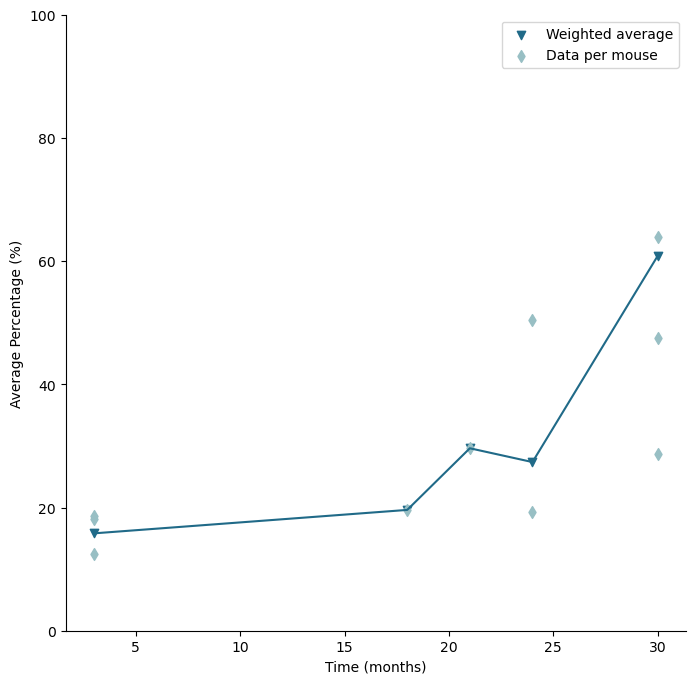

In [371]:
# reshape data
result_per_mouseT = result_per_mouse.T.reset_index()
per_mouse_ddr = result_per_mouseT[['index', 'mean']]
per_mouse_ddr.rename(columns={'mean': 'expression'}, inplace=True)
per_mouse_ddr['mouse_id'] = per_mouse_ddr['index']
per_mouse_ddr['timepoints'] = per_mouse_ddr['mouse_id'].str.split('-', n=1).str[0]
per_mouse_ddr.drop('index', inplace=True, axis = 1)


# add info: plate id, state variable, number of cells
per_mouse_ddr['plate_id'] = per_mouse_ddr.groupby('timepoints').cumcount() + 1
per_mouse_ddr['statevariable'] = 'DDR'
cell_list = []
for mouse in per_mouse_ddr['mouse_id']:
    cell_number = len(adata[adata.obs['donor_id'] == mouse])
    cell_list.append(cell_number)
per_mouse_ddr.loc[:, 'Num_cells'] = cell_list
per_mouse_ddr.drop('mouse_id', inplace=True, axis = 1)
#print(per_mouse_ddr)

# calculate weighted average based on total number of cells per mouse 
def weighted_average(group):
    return np.average(group['expression'], weights=group['Num_cells'])

per_mouse_ddr['timepoints']=  per_mouse_ddr['timepoints'].astype(int)
mean_timepoints = per_mouse_ddr.groupby('timepoints')['timepoints'].mean()
mean_expression = per_mouse_ddr.groupby('timepoints')['expression'].mean()
weighted_mean_expression = per_mouse_ddr.groupby('timepoints').apply(weighted_average).reset_index(drop=True)
weighted_mean_expression_ddr = weighted_mean_expression
print(mean_expression)

# plotting
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(mean_timepoints, weighted_mean_expression, color='#206A88', label='Weighted average', marker='v')
plt.scatter(per_mouse_ddr['timepoints'], per_mouse_ddr['expression'], color = '#98BFC4', label='Data per mouse', marker='d' )
plt.plot(mean_timepoints, weighted_mean_expression, color='#206A88',linestyle='-')
plt.xlabel('Time (months)')
plt.ylabel('Average Percentage (%)')
plt.legend()
ax = plt.gca() 
ax.set_ylim([0, 100])
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 


# Inflammation

In [372]:
gene_names = ['Nr2c2', 'Tab2', 'Ikbkg', 'Chuk', 'Ikbkb', 'Nfkbia', 'Nfkb1', 'Cdc37', 'Rela'] 
gene_names = ['Nr2c2', 'Tab2', 'Ikbkg', 'Chuk', 'Ikbkb', 'Nfkb1', 'Cdc37', 'Rela'] 

In [373]:
mouse_list = adata.obs['donor_id'].unique().tolist()
genes_per_age = pd.DataFrame(columns = ['Numeric_time'])
genes_per_mouse = pd.DataFrame(columns = ['Numeric_time'])
        
# selecting gene in dataset 
for gene_of_interest in gene_names:
    
    # extract numeric timepoints
    all_timepoints = adata.obs['age'].unique()
    timepoints_string = [str(timepoint) for timepoint in all_timepoints]
    timepoints_integer = [int(timepoint.split('m')[0]) for timepoint in timepoints_string]
    timepoints_sorted = [x for _, x in sorted(zip(timepoints_integer, all_timepoints))]

    adata_gene = adata[:, adata.var_names == gene_of_interest]
    expression_per_timepoint = pd.DataFrame(columns=['Gene', 'Timepoint', 'Numeric_time' ])

    # select timrpoint
    for timepoint in timepoints_sorted:
        adata_timepoint = adata_gene[adata_gene.obs['age'] == timepoint]
        expression_per_mouse =  pd.DataFrame(columns = ['Gene',  'Timepoint', 'Numeric_time' ])
        
        # select mouse
        for mouse in mouse_list:
            adata_mouse = adata_timepoint[adata_timepoint.obs['donor_id'] == mouse]    
            
            # make dataframe with gene expressions    
            expression_per_mouse.loc[0, 'Gene'] = gene_of_interest
            expression_per_mouse.loc[0, 'Timepoint'] = timepoint 
            expression_per_mouse['Numeric_time'] = expression_per_mouse['Timepoint'].str.split('m').str[0].astype(float)
            # calculate number of cells expressing the gene 
            expression_per_mouse[mouse] = (adata_mouse.X > 0).sum()
            # calculate total cells per mouse
            total_per_mouse = len(adata[adata.obs['donor_id'] == mouse])
            
            # calculate percentage of cells expressing the gene for cases with gene expression not 0
            if str(mouse).split('-')[0] == str(timepoint).split('m')[0] and expression_per_mouse[mouse].values[0] == 0:
                expression_per_mouse[mouse] = 0
            elif expression_per_mouse[mouse].values[0] == 0:
                    expression_per_mouse[mouse] = np.nan
            else: 
                expression_per_mouse[mouse] = expression_per_mouse[mouse] * 100 / total_per_mouse 

        # calculate mean for every timepoint (for case where there is more than 1 mouse)
        expression_per_mouse['Mean'] = expression_per_mouse.iloc[:, 3:].mean(axis=1)
        expression_per_mouse['Std'] = expression_per_mouse.iloc[:, 3:].std(axis=1)
        expression_per_timepoint = pd.concat([expression_per_timepoint, expression_per_mouse], ignore_index=True)

    genes_per_mouse = pd.concat([genes_per_mouse, expression_per_timepoint], ignore_index=True)

# mean of all genes per mouse
genes_per_mouse.drop(['Numeric_time', 'Gene', 'Timepoint', 'Mean', 'Std'], inplace=True, axis = 1)
result_per_mouse = genes_per_mouse.describe()
result_per_mouse

,18-F-51,21-F-54,24-M-59,30-M-3,30-M-4,30-M-5,3-F-56,3-F-57,24-M-58,3-M-8/9
count,8.000000,8.000000,8.000000,8.000000,8.00,8.000000,8.000000,8.000000,8.000000,8.000000
mean,20.703883,33.304498,45.370370,44.579715,43.75,29.411765,23.209635,24.231844,25.000000,20.960699
std,10.908375,16.090896,11.155116,24.772895,25.00,16.707352,14.733652,14.780545,15.084513,15.382004
min,8.155340,11.418685,25.925926,17.369727,25.00,9.803922,7.552083,8.938547,5.263158,4.585153
25%,13.640777,21.626298,43.518519,24.705335,25.00,19.117647,10.611979,14.385475,17.434211,10.152838
50%,18.543689,29.584775,50.000000,43.238213,31.25,26.143791,19.401042,17.877095,21.052632,15.829694
75%,26.941748,46.280277,51.851852,55.505583,56.25,38.235294,36.653646,34.078212,30.263158,30.567686
max,38.058252,55.709343,55.555556,91.253102,87.50,58.823529,42.968750,51.396648,53.947368,48.908297


C:\Users\Helene\AppData\Local\Temp\ipykernel_13680\1134642221.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_mouse_oi.rename(columns={'mean': 'expression'}, inplace=True)
C:\Users\Helene\AppData\Local\Temp\ipykernel_13680\1134642221.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_mouse_oi['mouse_id'] = per_mouse_oi['index']
C:\Users\Helene\AppData\Local\Temp\ipykernel_13680\1134642221.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

timepoints
3     22.800726
18    20.703883
21    33.304498
24    35.185185
30    39.247160
Name: expression, dtype: float64


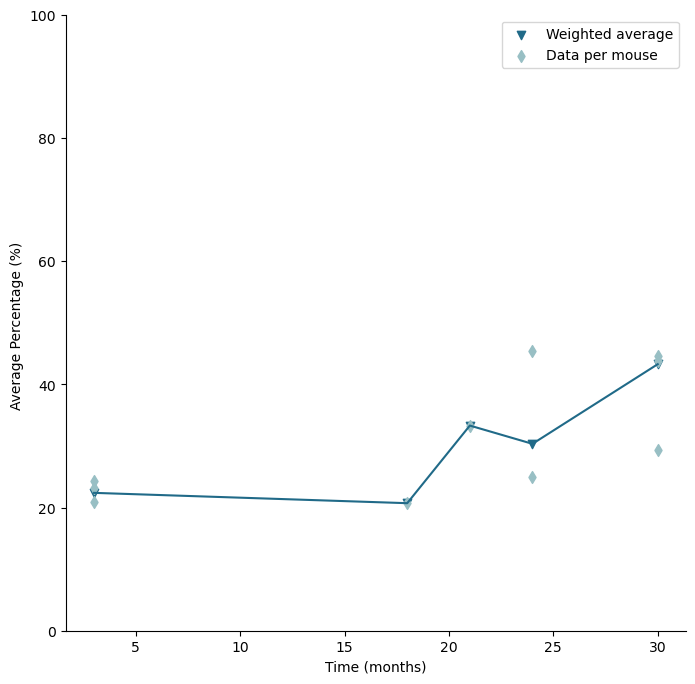

In [374]:
# reshape data
result_per_mouseT = result_per_mouse.T.reset_index()
per_mouse_oi = result_per_mouseT[['index', 'mean']]
per_mouse_oi.rename(columns={'mean': 'expression'}, inplace=True)
per_mouse_oi['mouse_id'] = per_mouse_oi['index']
per_mouse_oi['timepoints'] = per_mouse_oi['mouse_id'].str.split('-', n=1).str[0]
per_mouse_oi.drop('index', inplace=True, axis = 1)

# add info: plate id, state variable, number of cells
per_mouse_oi['plate_id'] = per_mouse_oi.groupby('timepoints').cumcount() + 1
per_mouse_oi['statevariable'] = 'OI'
cell_list = []
for mouse in per_mouse_oi['mouse_id']:
    cell_number = len(adata[adata.obs['donor_id'] == mouse])
    cell_list.append(cell_number)
per_mouse_oi.loc[:, 'Num_cells'] = cell_list
per_mouse_oi.drop('mouse_id', inplace=True, axis = 1)

# calculate weighted average based on total number of cells per mouse 
def weighted_average(group):
    return np.average(group['expression'], weights=group['Num_cells'])

per_mouse_oi['timepoints']=  per_mouse_oi['timepoints'].astype(int)
mean_timepoints = per_mouse_oi.groupby('timepoints')['timepoints'].mean()
mean_expression = per_mouse_oi.groupby('timepoints')['expression'].mean()
weighted_mean_expression = per_mouse_oi.groupby('timepoints').apply(weighted_average).reset_index(drop=True)
weighted_mean_expression_oi = weighted_mean_expression
print(mean_expression)

# plotting
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(mean_timepoints, weighted_mean_expression_oi, color='#206A88', label='Weighted average', marker='v')
plt.scatter(per_mouse_oi['timepoints'], per_mouse_oi['expression'], color = '#98BFC4', label='Data per mouse', marker='d' )
plt.plot(mean_timepoints, weighted_mean_expression_oi, color='#206A88',linestyle='-')
plt.xlabel('Time (months)')
plt.ylabel('Average Percentage (%) ')
plt.legend()
ax = plt.gca() 
ax.set_ylim([0, 100])
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 


# Inflammation signalling

In [375]:
gene_names = ['Ccl2', 'Ccl3', 'Ccl4', 'Ccl5', 'Cxcl2', 'Cxcl10'] 

In [376]:
mouse_list = adata.obs['donor_id'].unique().tolist()
genes_per_age = pd.DataFrame(columns = ['Numeric_time'])
genes_per_mouse = pd.DataFrame(columns = ['Numeric_time'])
        
# selecting gene in dataset 
for gene_of_interest in gene_names:
    
    # extract numeric timepoints
    all_timepoints = adata.obs['age'].unique()
    timepoints_string = [str(timepoint) for timepoint in all_timepoints]
    timepoints_integer = [int(timepoint.split('m')[0]) for timepoint in timepoints_string]
    timepoints_sorted = [x for _, x in sorted(zip(timepoints_integer, all_timepoints))]

    adata_gene = adata[:, adata.var_names == gene_of_interest]
    expression_per_timepoint = pd.DataFrame(columns=['Gene', 'Timepoint', 'Numeric_time' ])

    # select timrpoint
    for timepoint in timepoints_sorted:
        adata_timepoint = adata_gene[adata_gene.obs['age'] == timepoint]
        expression_per_mouse =  pd.DataFrame(columns = ['Gene',  'Timepoint', 'Numeric_time' ])
        
        # select mouse
        for mouse in mouse_list:
            adata_mouse = adata_timepoint[adata_timepoint.obs['donor_id'] == mouse]    
            
            # make dataframe with gene expressions    
            expression_per_mouse.loc[0, 'Gene'] = gene_of_interest
            expression_per_mouse.loc[0, 'Timepoint'] = timepoint 
            expression_per_mouse['Numeric_time'] = expression_per_mouse['Timepoint'].str.split('m').str[0].astype(float)
            # calculate number of cells expressing the gene 
            expression_per_mouse[mouse] = (adata_mouse.X > 0).sum()
            # calculate total cells per mouse
            total_per_mouse = len(adata[adata.obs['donor_id'] == mouse])
            
            # calculate percentage of cells expressing the gene for cases with gene expression not 0
            if str(mouse).split('-')[0] == str(timepoint).split('m')[0] and expression_per_mouse[mouse].values[0] == 0:
                expression_per_mouse[mouse] = 0
            elif expression_per_mouse[mouse].values[0] == 0:
                    expression_per_mouse[mouse] = np.nan
            else: 
                expression_per_mouse[mouse] = expression_per_mouse[mouse] * 100 / total_per_mouse 

        # calculate mean for every timepoint (for case where there is more than 1 mouse)
        expression_per_mouse['Mean'] = expression_per_mouse.iloc[:, 3:].mean(axis=1)
        expression_per_mouse['Std'] = expression_per_mouse.iloc[:, 3:].std(axis=1)
        expression_per_timepoint = pd.concat([expression_per_timepoint, expression_per_mouse], ignore_index=True)

    genes_per_mouse = pd.concat([genes_per_mouse, expression_per_timepoint], ignore_index=True)

# mean of all genes per mouse
genes_per_mouse.drop(['Numeric_time', 'Gene', 'Timepoint', 'Mean', 'Std'], inplace=True, axis = 1)
result_per_mouse = genes_per_mouse.describe()
result_per_mouse

,18-F-51,21-F-54,24-M-59,30-M-3,30-M-4,30-M-5,3-F-56,3-F-57,24-M-58,3-M-8/9
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.0,6.000000
mean,12.524272,4.036909,28.395062,89.454094,18.750000,17.647059,0.520833,0.465549,0.0,0.145560
std,10.093166,4.144553,14.184105,8.126504,6.846532,12.387302,0.368285,0.653098,0.0,0.112751
min,4.077670,1.384083,3.703704,74.937965,12.500000,5.228758,0.000000,0.000000,0.0,0.000000
25%,6.359223,1.816609,24.074074,86.972705,12.500000,8.986928,0.325521,0.000000,0.0,0.054585
50%,8.834951,2.076125,31.481481,92.090571,18.750000,13.071895,0.520833,0.279330,0.0,0.218341
75%,14.660194,4.152249,36.111111,94.742556,25.000000,27.941176,0.716146,0.558659,0.0,0.218341
max,31.262136,12.110727,44.444444,96.712159,25.000000,33.986928,1.041667,1.675978,0.0,0.218341


C:\Users\Helene\AppData\Local\Temp\ipykernel_13680\670974525.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_mouse_ia.rename(columns={'mean': 'expression'}, inplace=True)
C:\Users\Helene\AppData\Local\Temp\ipykernel_13680\670974525.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_mouse_ia['mouse_id'] = per_mouse_ia['index']
C:\Users\Helene\AppData\Local\Temp\ipykernel_13680\670974525.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

timepoints
3      0.377314
18    12.524272
21     4.036909
24    14.197531
30    41.950384
Name: expression, dtype: float64


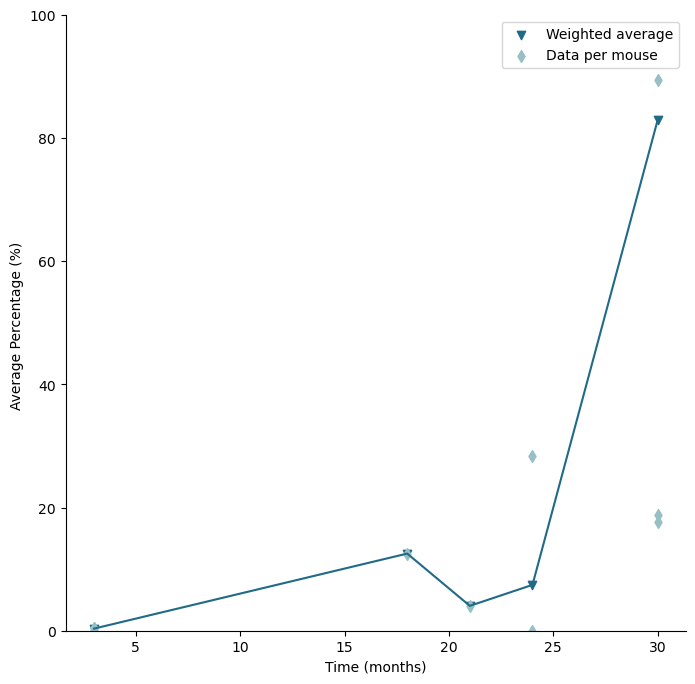

In [377]:
# reshape data
result_per_mouseT = result_per_mouse.T.reset_index()
per_mouse_ia = result_per_mouseT[['index', 'mean']]
per_mouse_ia.rename(columns={'mean': 'expression'}, inplace=True)
per_mouse_ia['mouse_id'] = per_mouse_ia['index']
per_mouse_ia['timepoints'] = per_mouse_ia['mouse_id'].str.split('-', n=1).str[0]
per_mouse_ia.drop('index', inplace=True, axis = 1)

# add info: plate id, state variable, number of cells
per_mouse_ia['plate_id'] = per_mouse_ia.groupby('timepoints').cumcount() + 1
per_mouse_ia['statevariable'] = 'IA'
cell_list = []
for mouse in per_mouse_ia['mouse_id']:
    cell_number = len(adata[adata.obs['donor_id'] == mouse])
    cell_list.append(cell_number)
per_mouse_ia.loc[:, 'Num_cells'] = cell_list
per_mouse_ia.drop('mouse_id', inplace=True, axis = 1)

# calculate weighted average based on total number of cells per mouse 
def weighted_average(group):
    return np.average(group['expression'], weights=group['Num_cells'])

per_mouse_ia['timepoints']=  per_mouse_ia['timepoints'].astype(int)
mean_timepoints = per_mouse_ia.groupby('timepoints')['timepoints'].mean()
mean_expression = per_mouse_ia.groupby('timepoints')['expression'].mean()
weighted_mean_expression = per_mouse_ia.groupby('timepoints').apply(weighted_average).reset_index(drop=True)
weighted_mean_expression_ia = weighted_mean_expression
print(mean_expression)

# plotting
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(mean_timepoints, weighted_mean_expression_ia, color='#206A88', label='Weighted average', marker='v')
plt.scatter(per_mouse_ia['timepoints'], per_mouse_ia['expression'], color = '#98BFC4', label='Data per mouse', marker='d' )
plt.plot(mean_timepoints, weighted_mean_expression_ia, color='#206A88',linestyle='-')
plt.xlabel('Time (months)')
plt.ylabel('Average Percentage (%) ')
plt.legend()
ax = plt.gca() 
ax.set_ylim([0, 100])
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 


# Senescence 

In [378]:
# reshape data
per_mouse_sen = pd.DataFrame(index = ['mouse_id'])
per_mouse_sen.index = adata.obs['donor_id'].unique()
per_mouse_sen['expression'] = adata.obs.groupby('donor_id')['sen_score_combined'].mean()
per_mouse_sen.reset_index(drop = False, inplace=True)
per_mouse_sen.rename(columns = {'index': 'mouse_id'}, inplace=True)
per_mouse_sen['timepoints'] = per_mouse_sen['mouse_id'].str.split('-', n=1).str[0].astype(int)


# add info: plate id, state variable, number of cells
per_mouse_sen['plate_id'] = per_mouse_sen.groupby('timepoints').cumcount() + 1
per_mouse_sen['statevariable'] = 'SC'
cell_list = []

for mouse in per_mouse_sen['mouse_id']:
    cell_number = len(adata[adata.obs['donor_id'] == mouse])
    cell_list.append(cell_number)
per_mouse_sen.loc[:, 'Num_cells'] = cell_list
per_mouse_sen.drop('mouse_id', axis = 1, inplace=True)

per_mouse_sen

,expression,timepoints,plate_id,statevariable,Num_cells
0,3.009547,18,1,SC,515
1,4.562750,21,1,SC,289
2,10.828179,24,1,SC,27
3,13.318953,30,1,SC,1612
4,1.126985,30,2,SC,8
5,3.688394,30,3,SC,153
6,2.159194,3,1,SC,384
7,2.355426,3,2,SC,179
8,4.088668,24,2,SC,76
9,1.823370,3,3,SC,458


timepoints
3     2.112663
18    3.009547
21    4.562750
24    7.458424
30    6.044777
Name: expression, dtype: float64


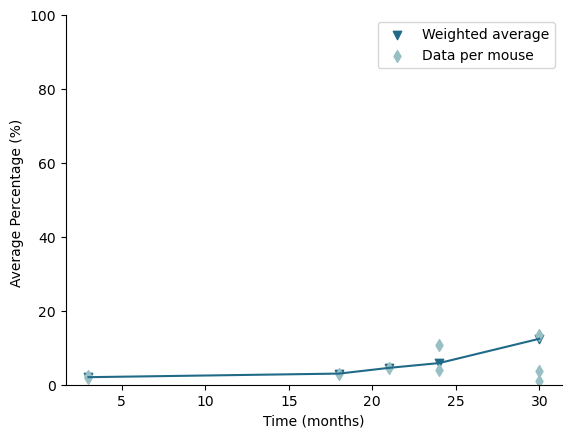

In [379]:
# calculate weighted average based on total number of cells per mouse 
def weighted_average(group):
    return np.average(group['expression'], weights=group['Num_cells'])

# plotting
per_mouse_sen['timepoints']=  per_mouse_sen['timepoints'].astype(int)
mean_timepoints = per_mouse_sen.groupby('timepoints')['timepoints'].mean()
mean_expression = per_mouse_sen.groupby('timepoints')['expression'].mean()
weighted_mean_expression = per_mouse_sen.groupby('timepoints').apply(weighted_average).reset_index(drop=True)
weighted_mean_expression_sen = weighted_mean_expression
print(mean_expression)

plt.scatter(mean_timepoints, weighted_mean_expression, color='#206A88', label='Weighted average', marker='v')
plt.scatter(per_mouse_sen['timepoints'], per_mouse_sen['expression'], color = '#98BFC4', label='Data per mouse', marker='d' )
plt.plot(mean_timepoints, weighted_mean_expression, color='#206A88',linestyle='-')
plt.xlabel('Time (months)')
plt.ylabel('Average Percentage (%) ')
plt.legend()
ax = plt.gca() 
ax.set_ylim([0, 100])
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
plt.show()

# Merge data and add insert theoretical dose

In [380]:
# fuse dataframes and save as csv for parameter fitting
all_pathways_activities = pd.concat([per_mouse_ddr, per_mouse_ia, per_mouse_sen], ignore_index=True, sort=False)

# add one dose or more doses
all_pathways_activities0 = all_pathways_activities.copy()
all_pathways_activities05 = all_pathways_activities.copy()
all_pathways_activities0['concentration'] = 0
all_pathways_activities05['concentration'] = 0.5


all_pathways_activities_merge = pd.concat([all_pathways_activities0, all_pathways_activities05], axis = 0)
all_pathways_activities_merge['timepoints'] = all_pathways_activities_merge['timepoints'].astype(int)
all_pathways_activities_merge = all_pathways_activities_merge[['statevariable', 'plate_id', 'concentration', 'timepoints','expression', 'Num_cells' ]]
all_pathways_activities_merge = all_pathways_activities_merge.sort_values(by= ['statevariable', 'concentration', 'timepoints'])
all_pathways_activities_merge

,statevariable,plate_id,concentration,timepoints,expression,Num_cells
6,DDR,1,0.0,3,18.645833,384
7,DDR,2,0.0,3,18.212291,179
9,DDR,3,0.0,3,12.489083,458
0,DDR,1,0.0,18,19.611650,515
1,DDR,1,0.0,21,29.619377,289
2,DDR,1,0.0,24,50.370370,27
8,DDR,2,0.0,24,19.210526,76
3,DDR,1,0.0,30,63.970223,1612
4,DDR,2,0.0,30,47.500000,8
5,DDR,3,0.0,30,28.758170,153


# Insert empty replicates

In [381]:
# count how many replicates there are initially
all_pathways_activities_merge['counting'] = all_pathways_activities_merge.apply(
    lambda row: str(row['statevariable']) + str(row['concentration']) + str(row['timepoints']),
    axis=1)

num_replicates = all_pathways_activities_merge.groupby('counting').size()
all_pathways_activities_merge['count_values'] = all_pathways_activities_merge['counting'].map(num_replicates)
all_pathways_activities_merge.reset_index(drop= True, inplace=True)

# where count is 3, no replicate has to be added

# dublicate a row where count is 2
selected_rows_double = all_pathways_activities_merge[(all_pathways_activities_merge['plate_id'] == 2) & (all_pathways_activities_merge['count_values'] == 2)].copy()
selected_rows_double['expression'] = pd.NA
selected_rows_double['flag'] = 'done'
merged_double = pd.concat([all_pathways_activities_merge, selected_rows_double], ignore_index=True)

# dublicate a row where count is 1 to get 2
selected_rows_single_1 = merged_double[(merged_double['plate_id'] == 1) & (merged_double['count_values'] == 1) & (merged_double['flag'] != 'done') ].copy()
selected_rows_single_1['expression'] = pd.NA
selected_rows_single_1['flag'] = 'done'
merged_single_1 = pd.concat([merged_double, selected_rows_single_1], ignore_index=True)

# dublicate another row where count is 1 to get 3
selected_rows_single_2 = merged_single_1[(merged_single_1['plate_id'] == 1) & (merged_single_1['count_values'] == 1) & (merged_double['flag'] != 'done') ].copy()
selected_rows_single_2['expression'] = pd.NA
selected_rows_single_2['flag'] = 'done'
merged_single_2 = pd.concat([merged_single_1, selected_rows_single_2], ignore_index=True)


inflated_data = merged_single_2.drop(['plate_id'], axis=1)
inflated_data.sort_values(['statevariable', 'concentration'], inplace= True)

# seperate for grouping
inflated_ddr =inflated_data[inflated_data['statevariable'] == 'DDR']
#inflated_oi =inflated_data[inflated_data['statevariable'] == 'OI']
inflated_ia =inflated_data[inflated_data['statevariable'] == 'IA']
inflated_sc =inflated_data[inflated_data['statevariable'] == 'SC']

# add new plate ids
inflated_ddr['plate_id'] = inflated_ddr.groupby(['concentration', 'timepoints']).cumcount() + 1
#inflated_oi['plate_id'] = inflated_oi.groupby(['concentration', 'timepoints']).cumcount() + 1
inflated_ia['plate_id'] = inflated_ia.groupby(['concentration', 'timepoints']).cumcount() + 1
inflated_sc['plate_id'] = inflated_sc.groupby(['concentration', 'timepoints']).cumcount() + 1

inflated_data = pd.concat([inflated_ddr, inflated_ia, inflated_sc])

# sort
inflated_data = inflated_data[['statevariable', 'plate_id', 'concentration', 'timepoints', 'expression', 'Num_cells']]
inflated_data.sort_values(['statevariable', 'plate_id', 'concentration', 'timepoints'], inplace= True)
inflated_data

C:\Users\Helene\AppData\Local\Temp\ipykernel_13680\1458157186.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inflated_ddr['plate_id'] = inflated_ddr.groupby(['concentration', 'timepoints']).cumcount() + 1
C:\Users\Helene\AppData\Local\Temp\ipykernel_13680\1458157186.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inflated_ia['plate_id'] = inflated_ia.groupby(['concentration', 'timepoints']).cumcount() + 1
C:\Users\Helene\AppData\Local\Temp\ipykernel_13680\1458157186.py:44: SettingWithCopyWarning:

,statevariable,plate_id,concentration,timepoints,expression,Num_cells
0,DDR,1,0.0,3,18.645833,384
3,DDR,1,0.0,18,19.611650,515
4,DDR,1,0.0,21,29.619377,289
5,DDR,1,0.0,24,50.370370,27
7,DDR,1,0.0,30,63.970223,1612
...,...,...,...,...,...,...
52,SC,3,0.5,3,1.823370,458
88,SC,3,0.5,18,NaN,515
89,SC,3,0.5,21,NaN,289
65,SC,3,0.5,24,NaN,76


# Scaling

In [382]:
# determine highest value
max_ddr = inflated_data.loc[inflated_data['statevariable'] == 'DDR', 'expression'].max()
#max_oi = inflated_data.loc[inflated_data['statevariable'] == 'OI', 'expression'].max()
max_ia = inflated_data.loc[inflated_data['statevariable'] == 'IA', 'expression'].max()
max_sc = inflated_data.loc[inflated_data['statevariable'] == 'SC', 'expression'].max()

print(max_ia)

# calculate scaling factors
factor_ddr = max_ddr/max_ia
#factor_oi = max_oi/max_ia
factor_sc = max_sc/max_ia

# apply scaling factor
inflated_data.loc[inflated_data['statevariable'] == 'DDR', 'expression'] = inflated_data.loc[inflated_data['statevariable'] == 'DDR', 'expression']*factor_ddr
#inflated_data.loc[inflated_data['statevariable'] == 'OI', 'expression'] = inflated_data.loc[inflated_data['statevariable'] == 'OI', 'expression']*factor_oi
inflated_data.loc[inflated_data['statevariable'] == 'SC', 'expression'] = inflated_data.loc[inflated_data['statevariable'] == 'SC', 'expression']*factor_sc
print(inflated_data[28:-30])
#print(inflated_data[:20])

89.45409429280397
   statevariable  plate_id  concentration  timepoints  expression  Num_cells
61           DDR         3            0.5          24         NaN         76
19           DDR         3            0.5          30   20.565482        153
20            IA         1            0.0           3    0.520833        384
23            IA         1            0.0          18   12.524272        515
24            IA         1            0.0          21    4.036909        289
25            IA         1            0.0          24   28.395062         27
27            IA         1            0.0          30   89.454094       1612
30            IA         1            0.5           3    0.520833        384
33            IA         1            0.5          18   12.524272        515
34            IA         1            0.5          21    4.036909        289
35            IA         1            0.5          24   28.395062         27
37            IA         1            0.5          30   89

Export data

In [383]:
# exprot as csv
#pathway_csv = inflated_data.to_csv('C:/Users/Helene/Documents/Master_Thesis/ODE/Model_6.0.3_23.01./pathwaydata.csv', index = False, na_rep='NA') 